# Scene Classification

## Overview
1. Preprocess
    - Import pkg
    - Import data
    - Show a sample
    - Shuffle split data
2. Analysis Features
3. Build Model
4. Train & Cross Validation
5. Predict

Reference:
- https://challenger.ai/competitions
- https://github.com/jupyter/notebook/issues/2287

## 3. Build Model

### Import pkg

In [1]:
import numpy as np
import pandas as pd
# import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

Using TensorFlow backend.


In [3]:
# import zipfile
import os
import zipfile
import math
from time import time
from IPython.display import display
import pdb
import json
from PIL import Image
import glob
import pickle

Load sample data, only first 1000 objects

In [4]:
input_path = './input'
extract_path = input_path + '/ai_challenger_scene_train_20170904'
scene_classes_path = extract_path + '/scene_classes.csv'

scene_classes = pd.read_csv(scene_classes_path, header=None)
display(scene_classes.head())

,0,1,2
0,0,航站楼,airport_terminal
1,1,停机坪,landing_field
2,2,机舱,airplane_cabin
3,3,游乐场,amusement_park
4,4,冰场,skating_rink


In [5]:
def get_scene_name(lable_number, scene_classes_path):
    scene_classes = pd.read_csv(scene_classes_path, header=None)
    return scene_classes.loc[lable_number, 2]
print(get_scene_name(0, scene_classes_path))

airport_terminal


In [6]:
x_data_path = './input/pickle/x_data0.p'
y_data_path = './input/pickle/y_data0.p'
x_data = pickle.load(open(x_data_path, mode='rb'))
y_data = pickle.load(open(y_data_path, mode='rb'))
print(x_data.shape)
print(y_data.shape)

(1000, 224, 224, 3)
(1000,)


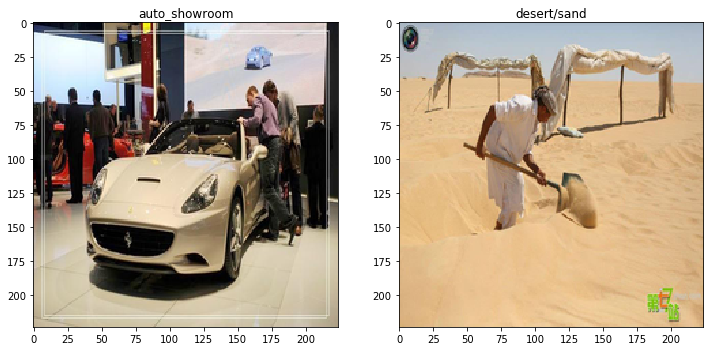

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(x_data[0])
ax[0].set_title(get_scene_name(y_data[0], scene_classes_path))
ax[1].imshow(x_data[1])
ax[1].set_title(get_scene_name(y_data[1], scene_classes_path))

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
print(y_train.shape)
print(y_val.shape)

(900, 80)
(100, 80)


In [9]:
def create_model():
    model = Sequential()

    model.add(Conv2D(filters = 32, strides=2, kernel_size = (3, 3), activation='relu',
                     input_shape = (224, 224, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 32, strides=2, kernel_size = (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 32, strides=2, kernel_size = (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 32, strides=2, kernel_size = (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 32, strides=2, kernel_size = (3, 3), activation='relu'))
    model.add(BatchNormalization())
    #model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
    #model.add(BatchNormalization())
    model.add(MaxPool2D(strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(80, activation='softmax'))
    return model

In [10]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

In [11]:
model = create_model()
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

In [12]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [13]:
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=2,
                           epochs=2, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_val, y_val), #For speed
                           callbacks=[annealer])

Epoch 1/2
6s - loss: 4.3983 - acc: 0.0312 - val_loss: 4.3840 - val_acc: 0.0200
Epoch 2/2
5s - loss: 4.5812 - acc: 0.0000e+00 - val_loss: 4.3836 - val_acc: 0.0200


In [14]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 4.3836, final accuracy: 0.0200


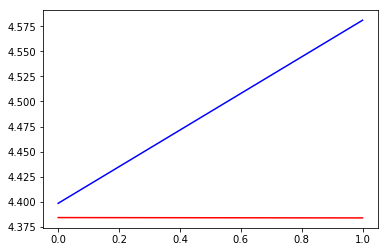

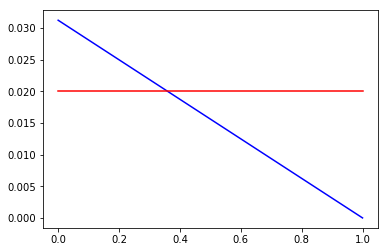

In [15]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [16]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


**Save model**

In [17]:
def saveModel(model):
    modelPath = './model'
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    fileName = modelPath + '/Conv2D' + time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())
    jsonFileName = fileName + '.json'
    yamlFileName = fileName + '.yaml'

    json_string = model.to_json()
    with open(jsonFileName, 'w') as file:
        file.write(json_string)
    yaml_string = model.to_yaml()
    with open(yamlFileName, 'w') as file:
        file.write(yaml_string)
    
    weigthsFile = fileName + '.h5'
    model.save(weigthsFile)
saveModel(model)

AttributeError: 'builtin_function_or_method' object has no attribute 'strftime'

In [ ]:
model0 = load_model('./model/Conv2D2017-09-12_22-35-23.h5')
final_loss, final_acc = model0.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))